<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/work/ML_classifier_averaging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification (with class labels)
***

# Import

In [1]:
!pip install vecstack==0.4.0 -q
!pip install yfinance==0.2.43 --q
#!pip install yfinance==0.2.28 -q
#!pip install -U scikit-learn==1.0

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.6/84.6 kB 2.4 MB/s eta 0:00:00


In [2]:
!pip install pandas-ta -q
#==0.2.45b

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from xgboost import XGBClassifier
from vecstack import stacking
import yfinance as yf
import numpy as np
import pandas as pd
import pandas_ta as ta
from pandas_datareader import data as pdr
START = "2018-12-01"  #yyyy-mm-dd
END = '2024-04-20' #2022-05-13 #2022-05-02
START_testing='2024-04-22'

In [4]:
trend_decider ='percentchange' #'percentchange' #'impulse' # 'sma'#'long' # percentchange
period=3
days_out=3
dictionary_bull={True:1, False:1}#{True:0.75, False:0.5}
dictionary_bear ={True:1,False:1}# {True:3,False:0.5}

In [5]:
def calculate_technical_indicators(df, fast_macd=12, slow_macd=26, signal_macd=9, vortex_length=8, aroon_length=8, rsi_length=8):
    """
    Calculates and appends technical indicators to a DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        fast_macd (int, optional): Fast period for MACD. Defaults to 12.
        slow_macd (int, optional): Slow period for MACD. Defaults to 26.
        signal_macd (int, optional): Signal period for MACD. Defaults to 9.
        vortex_length (int, optional): Length for Vortex indicator. Defaults to 18.
        aroon_length (int, optional): Length for Aroon indicator. Defaults to 18.
        rsi_length (int, optional): Length for RSI indicator. Defaults to 18.

    Returns:
        pd.DataFrame: The DataFrame with the calculated indicators appended.
    """
    for t in [0.25,0.5,0.75]:

      df.ta.macd(fast=fast_macd, slow=slow_macd, signal=signal_macd, append=True)
      df.ta.macd(fast=int(fast_macd * t), slow=int(slow_macd * t), signal=int(signal_macd * t), append=True)
      df.ta.vortex(length=vortex_length, append=True)
      df.ta.aroon(length=aroon_length, append=True)
      df.ta.rsi(length=rsi_length, append=True)
      df.ta.vortex(length=int(vortex_length * t), append=True)
      df.ta.aroon(length=int(aroon_length * t), append=True)
      df.ta.rsi(length=int(rsi_length * t), append=True)
    return df

In [6]:
def calculate_recent_price_action_features(df):
    """
    Calculate recent price action features for a given DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame with 'Date' as index and 'Close', 'Open', 'High', 'Low' columns

    Returns:
    pd.DataFrame: DataFrame with additional columns for recent price action features
    """

    # Ensure the DataFrame is sorted by date
    df = df.sort_index()

    # 1. Previous day's return
    df['prev_day_return'] = df['Close'].pct_change()

    # 2. Weekly return (5 trading days)
    df['weekly_return'] = df['Close'].pct_change(periods=5)

    # 3. Monthly return (21 trading days)
    df['monthly_return'] = df['Close'].pct_change(periods=21)

    # 4. Price momentum (3-day, 5-day, 10-day)
    for period in [3, 5, 10]:
        df[f'momentum_{period}d'] = df['Close'].pct_change(periods=period)

    # 5. Gap
    df['gap'] = (df['Open'] - df['Close'].shift(1)) / df['Close'].shift(1)

    # 6. Intraday price range
    df['intraday_range'] = (df['High'] - df['Low']) / df['Close']

    # 7. Distance from moving averages (5-day, 10-day MA)
    for period in [5, 10]:
        ma = df['Close'].rolling(window=period).mean()
        df[f'dist_from_ma_{period}d'] = (df['Close'] - ma) / ma

    # 8. Recent highs and lows (5-day window)
    df['near_high_5d'] = df['Close'] >= df['High'].rolling(window=5).max()
    df['near_low_5d'] = df['Close'] <= df['Low'].rolling(window=5).min()

    return df

# Prepare data

In [7]:
tker = '^nsei' #'^nsei'
nifty =yf.download(tker,start=START,end=END)
#nifty=quandl.get('BSE/BOM500112',start_date=START,end_date=END,authtoken='1Mz3xLNFNdUpKENCkArB')
#nifty = pdr.get_data_yahoo(tker, start=START, end=END)
nifty=nifty.dropna()
nifty=nifty.iloc[:,:4]

[*********************100%***********************]  1 of 1 completed


In [8]:
nifty.columns

Index(['Open', 'High', 'Low', 'Close'], dtype='object')

In [9]:
nifty=calculate_technical_indicators(nifty)
nifty=calculate_recent_price_action_features(nifty)

In [10]:
df_old = nifty.copy()
# I Just need the Close
price_data = df_old.copy()

In [11]:
features = price_data.columns.tolist()

#####df = df.assign(flag=df['apm'].gt(df['apm'].shift()))

In [12]:
if trend_decider=='impulse':
  price_data=price_data.assign(Flag=(price_data['MACDh_12_26_9'].lt(price_data['MACDh_12_26_9'].shift()) & price_data['ADV_13'].lt(price_data['ADV_13'].shift())))
elif trend_decider=='sma':
  price_data= price_data.assign(Flag=price_data['ADV_50'].lt(price_data['ADV_50'].shift()))
elif trend_decider=='long':
  price_data= price_data.assign(Flag=price_data['ADV_50'].lt(price_data['ADV_50'].shift(period)))
elif trend_decider=='percentchange':
  close_groups = price_data['Close'].transform(lambda x : np.sign(x.diff(days_out)))
  price_data['Flag'] = close_groups

# Calculate the conditions separately
condition1 = price_data['MACDh_12_26_9'] > price_data['MACDh_12_26_9'].shift()
condition2 = price_data['ADV_13'] > price_data['ADV_13'].shift()

# Create the Strength_Flag_dummy column
price_data['Strength_Flag_dummy'] = condition1 & condition2


In [13]:
#price_data=price_data.assign(Strength_Flag_dummy=(price_data['MACDh_12_26_9'].gt(price_data['MACDh_12_26_9'].shift()) & price_data['ADV_13'].gt(price_data['ADV_13'].shift())))

In [14]:
#price_data=price_data.assign(Strength_Flag_dum=(price_data['MACDh_12_26_9'].lt(price_data['MACDh_12_26_9'].shift()) & price_data['ADV_13'].lt(price_data['ADV_13'].shift())))

In [15]:
price_data.dropna(inplace=True)

In [16]:
#price_data.Strength_Flag_dummy.value_counts()

In [17]:
#price_data.Strength_Flag_dummy = price_data.Strength_Flag_dummy.replace(dictionary_bull)

In [18]:
#price_data.Strength_Flag_dum.value_counts()

In [19]:
#price_data.Strength_Flag_dum = price_data.Strength_Flag_dum.replace(dictionary_bear)

In [20]:
#price_data['Strength_Flag']=price_data.Strength_Flag_dum+price_data.Strength_Flag_dummy

In [21]:
X_Cols = price_data[features]
Y_Cols = price_data['Flag']
samp_train= int(len(price_data)*.75) -100
samp_test= samp_train+100
X_train = X_Cols[:samp_train]
X_test = X_Cols[samp_test:]
y_train = Y_Cols[:samp_train]
y_test = Y_Cols[samp_test:]

# Initialize 1st level models

In [22]:
#sample_w=price_data[:samp_train].Strength_Flag.values

In [23]:
models_L1 = [
    LogisticRegression(max_iter=12000),
    svm.SVC(kernel='linear'),
    ExtraTreesClassifier(random_state=0, n_jobs=-1,
                         n_estimators=100, max_depth=3,class_weight='balanced' ),

    RandomForestClassifier(random_state=0, n_jobs=-1,
                           n_estimators=500, max_depth=3,class_weight='balanced'),

    LDA(solver='svd', shrinkage=None, priors=None, n_components=None,
        store_covariance=False, tol=0.0001, covariance_estimator=None),

]

In [24]:
'''XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1,sample_weight=sample_w,
                  n_estimators=100, max_depth=3)'''

'XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1,sample_weight=sample_w,\n                  n_estimators=100, max_depth=3)'

In [25]:
model_L1_0 = models_L1[0]
_ = model_L1_0.fit(X_train, y_train)
# save model in file if you need

model_L1_1 = models_L1[1]
_ = model_L1_1.fit(X_train, y_train)#sample_weight=sample_w
# save model in file if you need

model_L1_2 = models_L1[2]
_ = model_L1_2.fit(X_train, y_train)#,sample_weight=sample_w
# save model in file if you need

model_L1_3 = models_L1[3]
_ = model_L1_3.fit(X_train, y_train)
# save model in file if you need
model_L1_4 = models_L1[4]
_ = model_L1_4.fit(X_train, y_train)
# save model in file if you need

# save model in file if you need



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [26]:
model_L1_3.feature_importances_

array([3.23935197e-04, 3.38840642e-04, 5.58811167e-04, 3.59806575e-04,
       3.40246118e-04, 2.34024327e-04, 2.46399668e-04, 1.91441468e-02,
       1.07528396e-02, 2.12115298e-03, 5.68739115e-04, 6.05121390e-04,
       1.28633590e-03, 4.45557495e-04, 3.49135956e-04, 6.83404127e-03,
       5.20988106e-02, 8.08525607e-02, 2.76891010e-02, 2.12113413e-02,
       8.57878414e-02, 5.89687614e-02, 9.39382889e-04, 4.26910050e-02,
       4.25771683e-04, 1.31451881e-02, 5.98228515e-03, 2.31100314e-02,
       1.77078825e-02, 1.20270000e-02, 7.18104018e-02, 6.43701762e-04,
       9.44518837e-04, 3.08158054e-04, 1.34900376e-03, 5.31837422e-04,
       3.93517360e-03, 1.80789018e-03, 3.32321750e-04, 1.51662446e-02,
       1.57085084e-03, 3.18769401e-03, 2.19288808e-04, 2.37442292e-01,
       6.20950435e-03, 4.96492856e-04, 8.59132314e-04, 2.87800075e-04,
       1.35818870e-01, 2.99327256e-02, 0.00000000e+00, 0.00000000e+00])

In [27]:
importances = model_L1_3.feature_importances_
data = {'feature_name': features, 'importance': importances*100}
df = pd.DataFrame(data)

In [28]:
df = df.sort_values(by='importance')
print(df)

        feature_name  importance
51       near_low_5d    0.000000
50      near_high_5d    0.000000
42    monthly_return    0.021929
5      MACDh_12_26_9    0.023402
6      MACDs_12_26_9    0.024640
47    intraday_range    0.028780
33      MACDs_9_19_6    0.030816
0               Open    0.032394
38        AROONOSC_6    0.033232
1               High    0.033884
4       MACD_12_26_9    0.034025
14        AROONOSC_8    0.034914
3              Close    0.035981
24      MACDs_6_13_4    0.042577
13          AROONU_8    0.044556
45      momentum_10d    0.049649
35            VTXM_6    0.053184
2                Low    0.055881
10            VTXP_8    0.056874
11            VTXM_8    0.060512
31       MACD_9_19_6    0.064370
46               gap    0.085913
22       MACD_6_13_4    0.093938
32      MACDh_9_19_6    0.094452
12          AROOND_8    0.128634
34            VTXP_6    0.134900
40   prev_day_return    0.157085
37          AROONU_6    0.180789
9        MACDs_3_6_2    0.212115
41     wee

# Perform stacking

In [29]:
S_train, S_test = stacking(models_L1,                     # list of models
                           X_train, y_train, X_test,   # data
                           regression=False,           # classification task (if you need
                                                       #     regression - set to True)
                           mode='oof',                 # mode: oof for train set, predict test
                                                       #mode='oof_pred_bag'(for training) and oof for inference
                                                      #     set in each fold and vote
                           needs_proba=False,          # predict class labels (if you need
                                                       #     probabilities - set to True)
                           save_dir=None,              # do not save result and log (to save
                                                       #     in current dir - set to '.')
                           metric=accuracy_score,      # metric: callable
                           n_folds=4,                  # number of folds
                           stratified=True,            # stratified split for folds
                           shuffle=False,               # shuffle the data
                           random_state=None,             # ensure reproducibility
                           verbose=2)                  # print all info

task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof]
n_models:     [5]

model  0:     [LogisticRegression]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


    fold  0:  [0.91743119]


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


    fold  1:  [0.94009217]


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


    fold  2:  [0.94470046]


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


    fold  3:  [0.89861751]
    ----
    MEAN:     [0.92521033] + [0.01850018]
    FULL:     [0.92520138]

model  1:     [SVC]
    fold  0:  [0.88990826]
    fold  1:  [0.89861751]
    fold  2:  [0.92165899]
    fold  3:  [0.89400922]
    ----
    MEAN:     [0.90104849] + [0.01229185]
    FULL:     [0.90103567]

model  2:     [ExtraTreesClassifier]
    fold  0:  [0.88073394]
    fold  1:  [0.95391705]
    fold  2:  [0.92165899]
    fold  3:  [0.89400922]
    ----
    MEAN:     [0.91257980] + [0.02806343]
    FULL:     [0.91254315]

model  3:     [RandomForestClassifier]
    fold  0:  [0.98165138]
    fold  1:  [0.99078341]
    fold  2:  [0.97235023]
    fold  3:  [0.97235023]
    ----
    MEAN:     [0.97928381] + [0.00764845]
    FULL:     [0.97928654]

model  4:     [LinearDiscriminantAnalysis]
    fold  0:  [0.91743119]
    fold  1:  [0.94009217]
    fold  2:  [0.94470046]
    fold  3:  [0.92165899]
    ----
    MEAN:     [0.93097070] + [0.01163759]
    FULL:     [0.93095512]



# Look at the result

So now we have OOF from 1st level models and we can build 2nd level model.  
But first let's look at the result.  
We have three 1st level models, so we expect to get three columns in `S_train` and `S_test`.  

In [30]:
# XGboost
model_L1_X = XGBClassifier(learning_rate =0.1,
 n_estimators=100,
 max_depth=3,
 min_child_weight=1,
 gamma=0,
 reg_alpha= 0.01,
 subsample=0.75,
 colsample_bytree=0.75,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
# Fit 2nd level model
dummy_train = model_L1_X.fit(X_train,y_train)
# Predict
#y_pred = model_L2.predict(S_test)

# Final prediction score
#print('Final prediction score: [%.8f]' % accuracy_score(y_test, y_pred))

# Apply 2nd level model

In [31]:
'''
# Initialize 2nd level model
model_L2 = XGBClassifier(learning_rate =0.1,
 n_estimators=100,
 max_depth=3,
 min_child_weight=1,
 gamma=0,
 reg_alpha= 0.01,
 subsample=0.75,
 colsample_bytree=0.75,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
S_train=np.c_[S_train,dummy_train]
# Fit 2nd level model
_ = model_L2.fit(S_train,y_train)
# Predict
y_pred = model_L2.predict(S_test)

# Final prediction score
#print('Final prediction score: [%.8f]' % accuracy_score(y_test, y_pred))
'''

"\n# Initialize 2nd level model\nmodel_L2 = XGBClassifier(learning_rate =0.1,\n n_estimators=100,\n max_depth=3,\n min_child_weight=1,\n gamma=0,\n reg_alpha= 0.01,\n subsample=0.75,\n colsample_bytree=0.75,\n objective= 'binary:logistic',\n nthread=4,\n scale_pos_weight=1,\n seed=27)\nS_train=np.c_[S_train,dummy_train]\n# Fit 2nd level model\n_ = model_L2.fit(S_train,y_train)\n# Predict\ny_pred = model_L2.predict(S_test)\n\n# Final prediction score\n#print('Final prediction score: [%.8f]' % accuracy_score(y_test, y_pred))\n"

# Make Predictions

In [32]:
nifty_test=yf.download(tker,start=START_testing)

[*********************100%***********************]  1 of 1 completed


In [33]:
#nifty_test = pdr.get_data_yahoo(tker, start=START)
nifty_test=nifty_test.dropna()
nifty_test=nifty_test.iloc[:,:4]

In [34]:
nifty_test=calculate_technical_indicators(nifty_test)
nifty_test=calculate_recent_price_action_features(nifty_test)
df = nifty_test.copy()
# I Just need the Close
price_data_new = df.copy()

price_data_new.tail(2)

,Open,High,Low,Close,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,MACD_3_6_2,MACDh_3_6_2,MACDs_3_6_2,...,monthly_return,momentum_3d,momentum_5d,momentum_10d,gap,intraday_range,dist_from_ma_5d,dist_from_ma_10d,near_high_5d,near_low_5d
Date,,,,,,,,,,,,,,,,,,,,,
2025-01-15,23250.449219,23293.650391,23146.449219,23213.199219,-246.355997,-57.917177,-188.438820,-108.143133,10.679434,-118.822567,...,-0.058985,-0.009317,-0.020083,-0.02231,0.003210,0.006341,-0.003154,-0.014885,False,False
2025-01-16,23377.250000,23391.650391,23272.050781,23311.800781,-243.919646,-44.384660,-199.534985,-59.137290,19.895092,-79.032383,...,-0.042086,0.009783,-0.009126,-0.03625,0.007067,0.005130,0.002930,-0.007006,False,False


In [35]:
# Group by the `Symbol` column, then grab the `Close` column.
#close_groups = price_data_new['Close']

# Apply the lambda function which will return -1.0 for down, 1.0 for up and 0.0 for no change.
#close_groups = close_groups.transform(lambda x : np.sign(x.diff(days_out)))

# add the data to the main dataframe.
#price_data_new['Prediction'] = close_groups
price_data_new = price_data_new.dropna()

X_test_new =price_data_new[features]
#Y_Cols = price_data_new['Prediction']




In [36]:
#[4] Then new test set (X_test_new) comes. We load our 1st level models and predict new test set to get stacked features (S_test_new):
y_pred_L1_0 = model_L1_0.predict(X_test_new)
y_pred_L1_1 = model_L1_1.predict(X_test_new)
y_pred_L1_2 = model_L1_2.predict(X_test_new)
y_pred_L1_3 = model_L1_3.predict(X_test_new)
y_pred_L1_4 = model_L1_4.predict(X_test_new)

#y_pred_l1_6= model_L1_X.predict(X_test_new)
S_test_new = np.c_[y_pred_L1_0, y_pred_L1_1,y_pred_L1_2,y_pred_L1_3,y_pred_L1_4]
#[5] Then we load our 2nd level model and predict S_test_new to get final prediction:

#y_pred_new = model_L2.predict(S_test_new)


In [37]:
S_test_new[-5:]#.sum(axis=1)

array([[-1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [ 1.,  1.,  1.,  1.,  1.]])

In [38]:
y_pred_new_p = S_test_new.sum(axis=1)

In [39]:
y_pred_new_p

array([ 5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  3.,  1.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5., -5., -5.,  5.,  5.,  5.,
        5., -3., -5., -5., -5., -5.,  5.,  5.,  5.,  5.,  5., -5., -5.,
       -5., -5., -3.,  5.,  5., -3., -5.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5., -5., -5., -5., -5., -5., -1.,
        5.,  5.,  5.,  5.,  5.,  1.,  5.,  5.,  5.,  5.,  5.,  5., -5.,
       -5., -5., -5., -5., -5., -3.,  3., -3.,  5.,  5., -5., -5., -5.,
       -5., -5., -5., -5., -5., -3.,  5.,  5., -1., -5., -5., -5.,  5.,
        3., -5., -5., -5., -5., -5., -5., -5., -5.,  5.,  5.,  5.,  5.,
       -5., -5., -1.,  5.,  5.,  5.,  5.,  5., -5., -5., -5.,  3.,  3.,
       -5., -5., -5., -5., -5., -5., -3.,  5., -5., -5., -5.,  5.,  5.,
       -5., -5., -5., -5., -5., -5., -5., -5.,  5.])

In [40]:
'''
price_data_new=price_data_new.assign(Strength_Flag_dummy=(price_data_new['MACDh_12_26_9'].gt(price_data_new['MACDh_12_26_9'].shift()) & price_data_new['ADV_13'].gt(price_data_new['ADV_13'].shift())))
price_data_new=price_data_new.assign(Strength_Flag_dum=(price_data_new['MACDh_12_26_9'].lt(price_data_new['MACDh_12_26_9'].shift()) & price_data_new['ADV_13'].lt(price_data_new['ADV_13'].shift())))
price_data_new.dropna(inplace=True)
price_data_new.Strength_Flag_dum = price_data_new.Strength_Flag_dum.replace(dictionary_bear)
price_data_new.Strength_Flag_dummy = price_data_new.Strength_Flag_dummy.replace(dictionary_bull)
price_data_new['Strength_Flag']=price_data_new.Strength_Flag_dum+price_data_new.Strength_Flag_dummy
'''

"\nprice_data_new=price_data_new.assign(Strength_Flag_dummy=(price_data_new['MACDh_12_26_9'].gt(price_data_new['MACDh_12_26_9'].shift()) & price_data_new['ADV_13'].gt(price_data_new['ADV_13'].shift())))\nprice_data_new=price_data_new.assign(Strength_Flag_dum=(price_data_new['MACDh_12_26_9'].lt(price_data_new['MACDh_12_26_9'].shift()) & price_data_new['ADV_13'].lt(price_data_new['ADV_13'].shift())))\nprice_data_new.dropna(inplace=True)\nprice_data_new.Strength_Flag_dum = price_data_new.Strength_Flag_dum.replace(dictionary_bear)\nprice_data_new.Strength_Flag_dummy = price_data_new.Strength_Flag_dummy.replace(dictionary_bull)\nprice_data_new['Strength_Flag']=price_data_new.Strength_Flag_dum+price_data_new.Strength_Flag_dummy\n"

In [41]:
#price_data_new.Strength_Flag = price_data_new.Strength_Flag.replace(dictionary)

In [42]:
#price_data_new.tail(2)

In [43]:
'''
if trend_decider !='percentchange':
  #price_data_new.Flag = price_data_new.Flag.replace({True: 0, False: 1})
  y_pred_new=y_pred_new.astype(int)
  indices_one = y_pred_new == 1
  indices_zero = y_pred_new == 0
  y_pred_new[indices_one] = 0 # replacing 1s with 0s
  y_pred_new[indices_zero] = 1 # replacing 0s with 1s
if trend_decider =='percentchange':
  #price_data_new.Flag = np.where(price_data_new.close>price_data_new.close.shift(1),1,-1)
  print('done')
'''

"\nif trend_decider !='percentchange':\n  #price_data_new.Flag = price_data_new.Flag.replace({True: 0, False: 1})\n  y_pred_new=y_pred_new.astype(int)\n  indices_one = y_pred_new == 1\n  indices_zero = y_pred_new == 0\n  y_pred_new[indices_one] = 0 # replacing 1s with 0s\n  y_pred_new[indices_zero] = 1 # replacing 0s with 1s\nif trend_decider =='percentchange':\n  #price_data_new.Flag = np.where(price_data_new.close>price_data_new.close.shift(1),1,-1)\n  print('done')\n"

In [44]:
#actuals=price_data_new['Flag'].dropna()
#actuals.value_counts()

rapida = 18
lenta = 26
stdv = 0.5
df['fast'] =df['Close'].ewm(span=rapida).mean()
df['slow'] =df['Close'].ewm(span=lenta).mean()
df['bband']= df['fast']-df['slow']
df['avg'] = df['bband'].rolling(window=9).mean()
df['Sdev'] = df['bband'].rolling(window=9).std()
df['Upper Band'] = df['avg'] + (df['Sdev'] *stdv)
df['Lower Band'] = df['avg'] - (df['Sdev'] *stdv)

In [45]:
rapida = 2*1.2
lenta = 6*1.2
stdv =0.8
df['fast'] =df['Close'].ewm(span=rapida).mean()
df['slow'] =df['Close'].ewm(span=lenta).mean()
df['bband']= df['fast']-df['slow']
df['avg'] = df['bband'].rolling(window=10).mean()
df['Sdev'] = df['bband'].rolling(window=12).std()
df['Upper Band'] = df['avg'] + (df['Sdev'] *stdv)
df['Lower Band'] = df['avg'] - (df['Sdev'] *stdv)
df['spread'] = df['bband'] - df['Lower Band']
df['spread_1'] = -(df['bband'] - df['Upper Band'])

In [46]:
df['dnsignal']=np.where(df['spread_1']>df['spread_1'].rolling(window=30).mean(),-1,0)
df['upsignal']=np.where(df['spread']>df['spread'].rolling(window=30).mean(),1,0)

In [47]:
buy= np.where(y_pred_new_p>=0)
sell= np.where(y_pred_new_p<0) #0 if impulse !!!


In [48]:
price_data_new.shape,y_pred_new_p.shape

((152, 52), (152,))

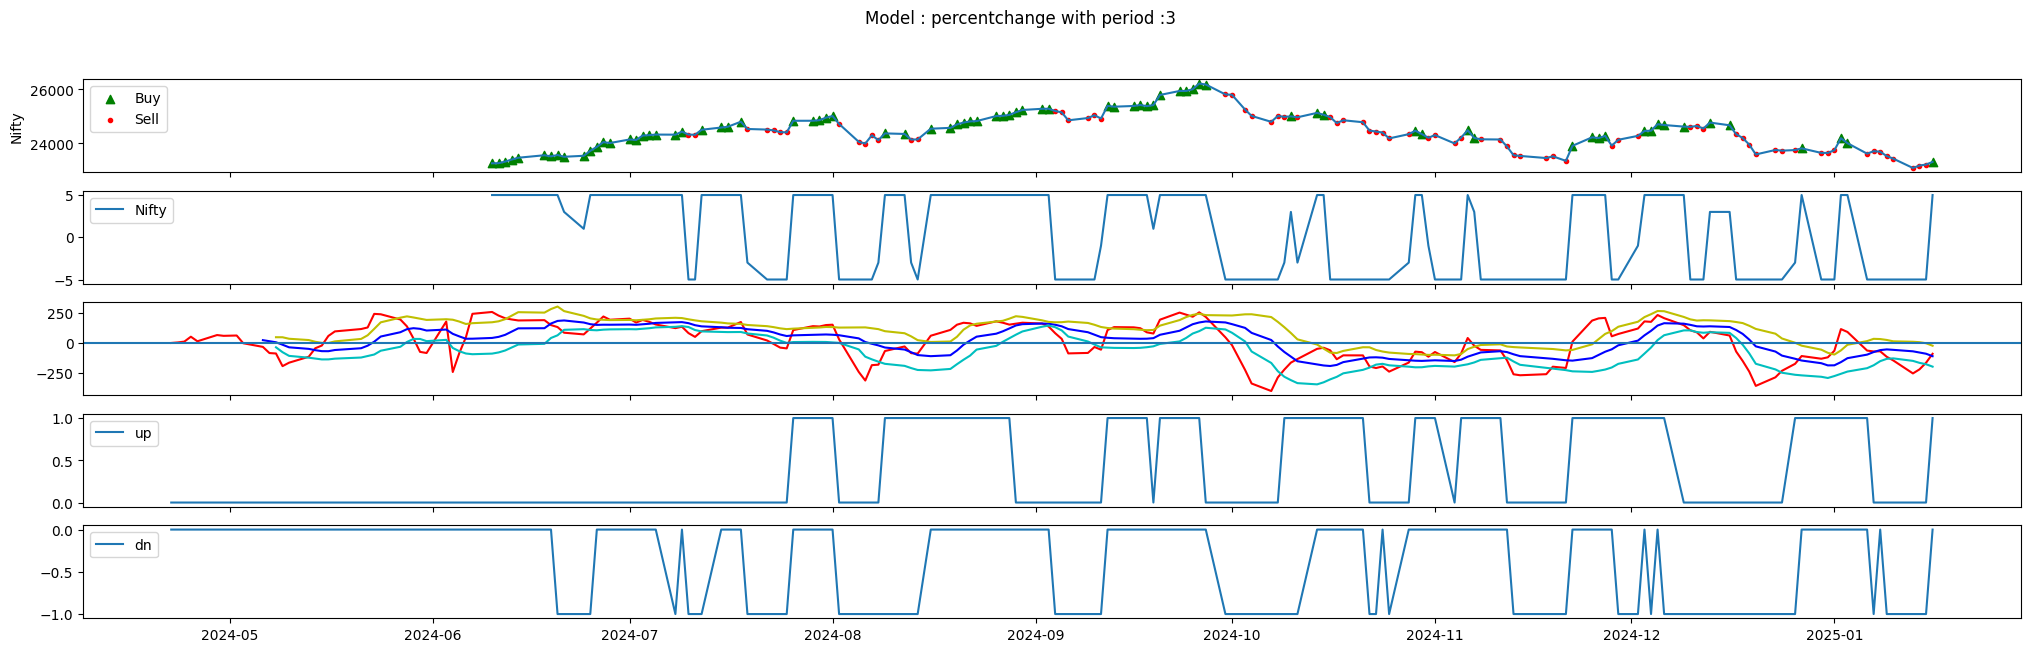

In [49]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(5,1, figsize=(25,7),sharex=True)
ax[0].plot(price_data_new.loc[:, :].index, price_data_new.loc[:, 'Close'])
ax[1].plot(price_data_new.loc[:, :].index, y_pred_new_p, label='Nifty')
ax[0].scatter(price_data_new.iloc[buy].index,price_data_new.iloc[buy].Close,marker='^',label='Buy',color='g')
ax[0].scatter(price_data_new.iloc[sell].index,price_data_new.iloc[sell].Close,marker='.',label='Sell',color='r')
ax[2].plot(df[['bband']][:],color='r')
ax[2].plot(df[['avg',]][:],color='b')
ax[2].plot(df[['Upper Band',]][:],color='y')
ax[2].plot(df[['Lower Band']][:],color='c')
ax[2].axhline(y=0)
ax[3].plot(df['upsignal'] , label='up')
ax[4].plot(df['dnsignal'],label='dn')
ax[0].legend(loc='upper left')
ax[3].legend(loc='upper left')
ax[4].legend(loc='upper left')
ax[0].set_ylabel('Nifty')
ax[1].legend('ML Signal')
ax[1].legend(loc='best')
fig.suptitle('Model : '+ trend_decider +' with period :' + str(period))
plt.savefig('ml.png')
plt.show()


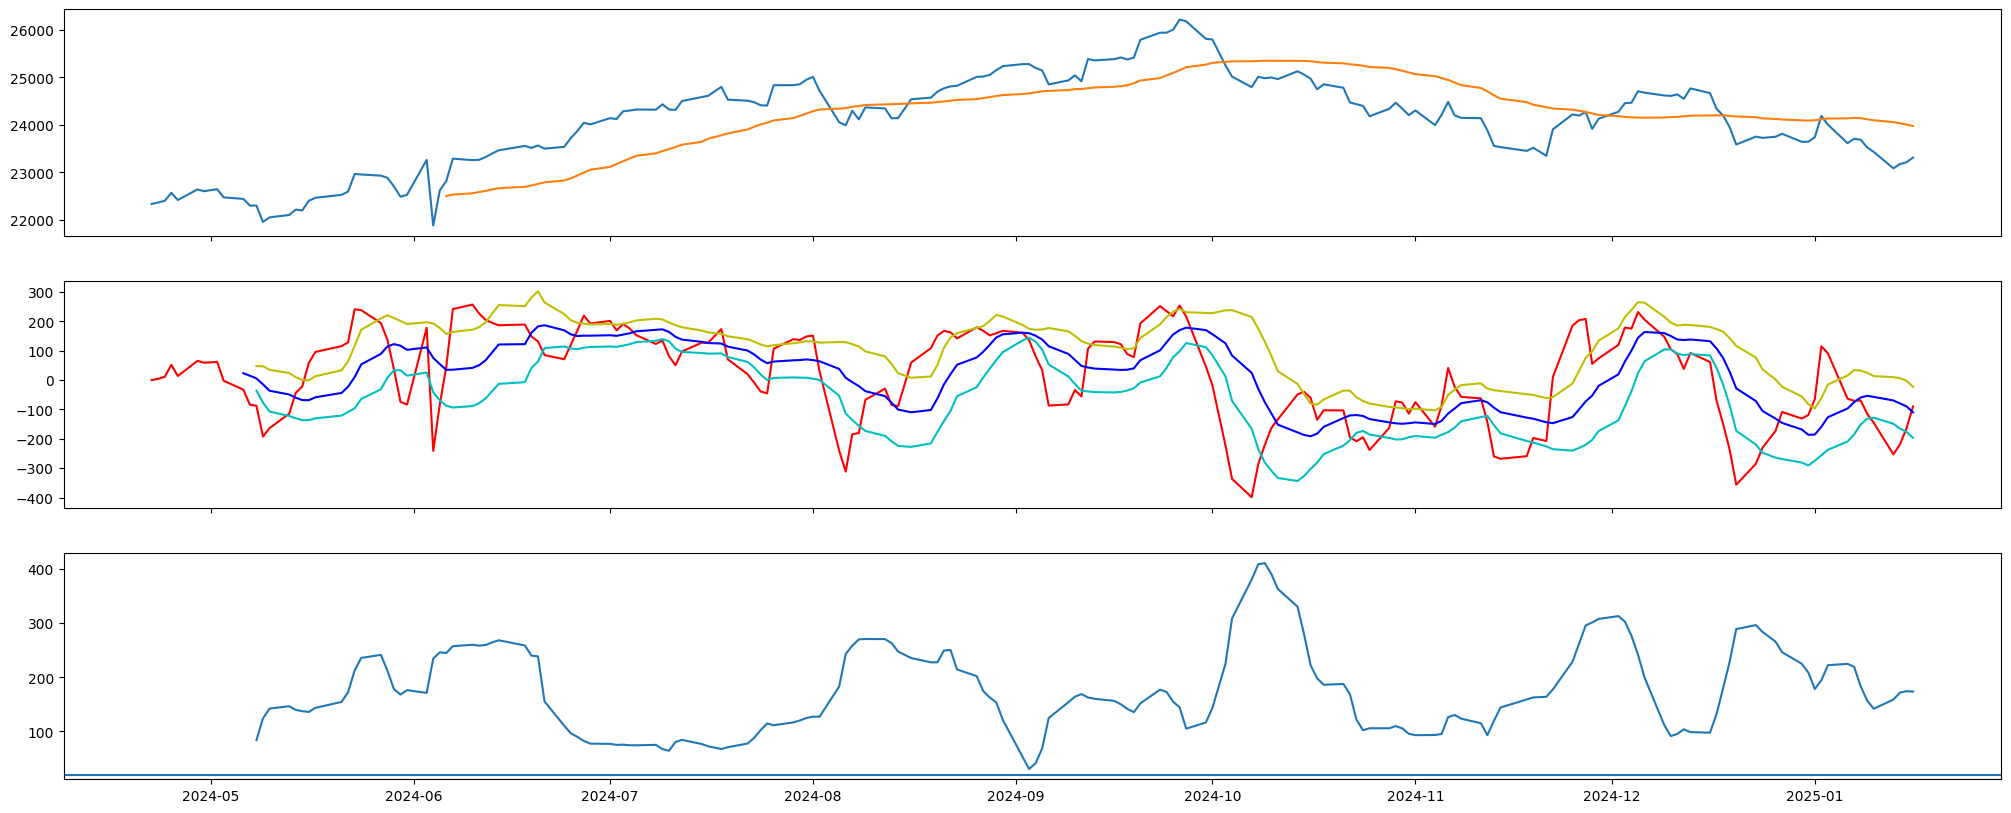

In [50]:
fig, ax = plt.subplots(3,1, figsize=(25,10),sharex=True)
ax[0].plot(df.loc[:, 'Close'])
ax[0].plot(df.loc[:,'Close'].rolling(window=32).mean())
ax[1].plot(df[['bband']][:],color='r')
ax[1].plot(df[['avg',]][:],color='b')
ax[1].plot(df[['Upper Band',]][:],color='y')
ax[1].plot(df[['Lower Band']][:],color='c')
ax[2].plot(df['Upper Band']-df['Lower Band'])
ax[2].axhline(y=20)
plt.show()

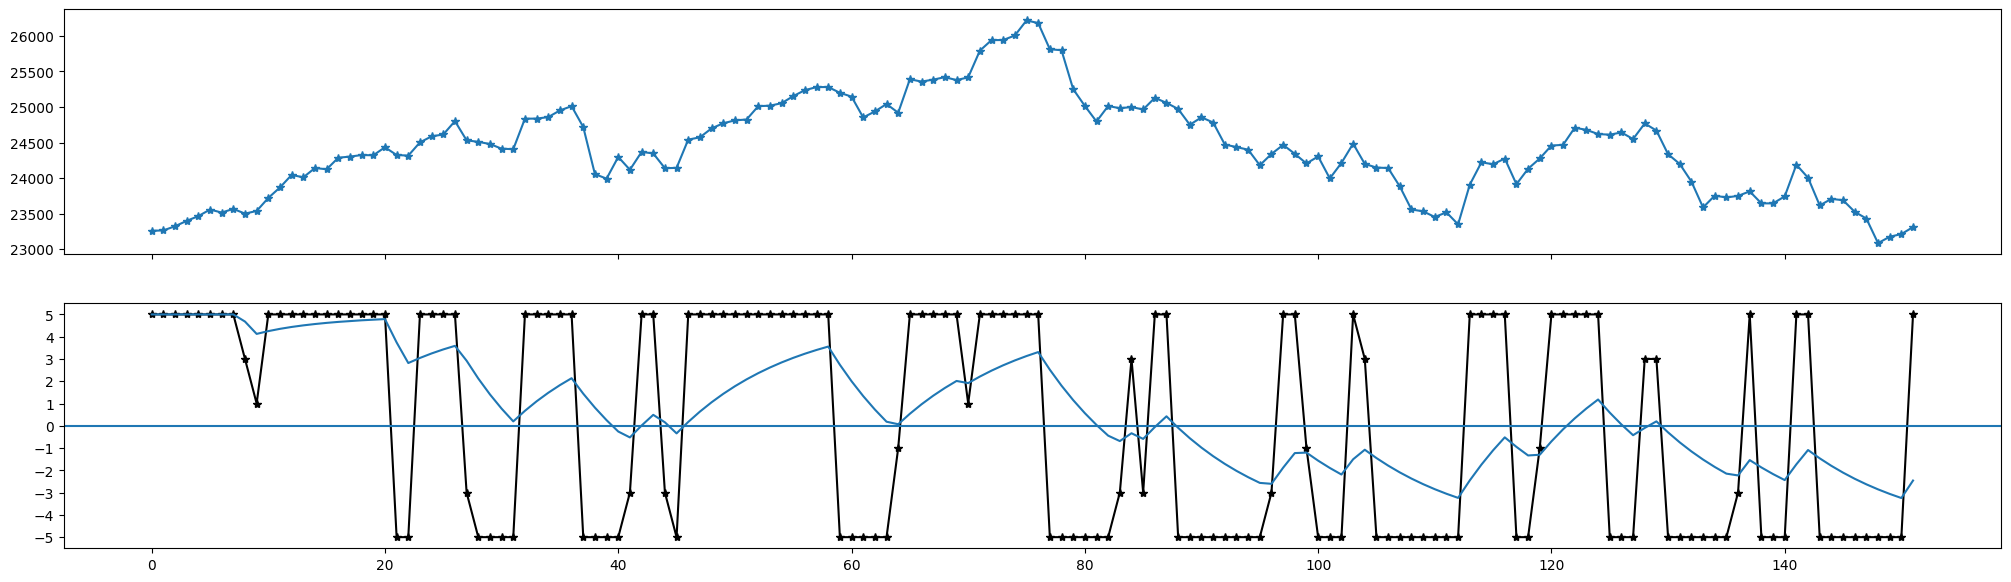

In [51]:
fig, ax = plt.subplots(2,1, figsize=(25,7),sharex=True)
ax[0].plot(pd.Series(price_data_new['Close'].values,),'*-')
rng = np.arange(-9,8,1)
ax[1].set_yticks(rng)
ax[1].plot(pd.Series(S_test_new[:].sum(axis=1)),'k*-')
ax[1].plot(pd.Series(S_test_new[:].sum(axis=1)).ewm(span=20).mean())
ax[1].axhline(y=0);

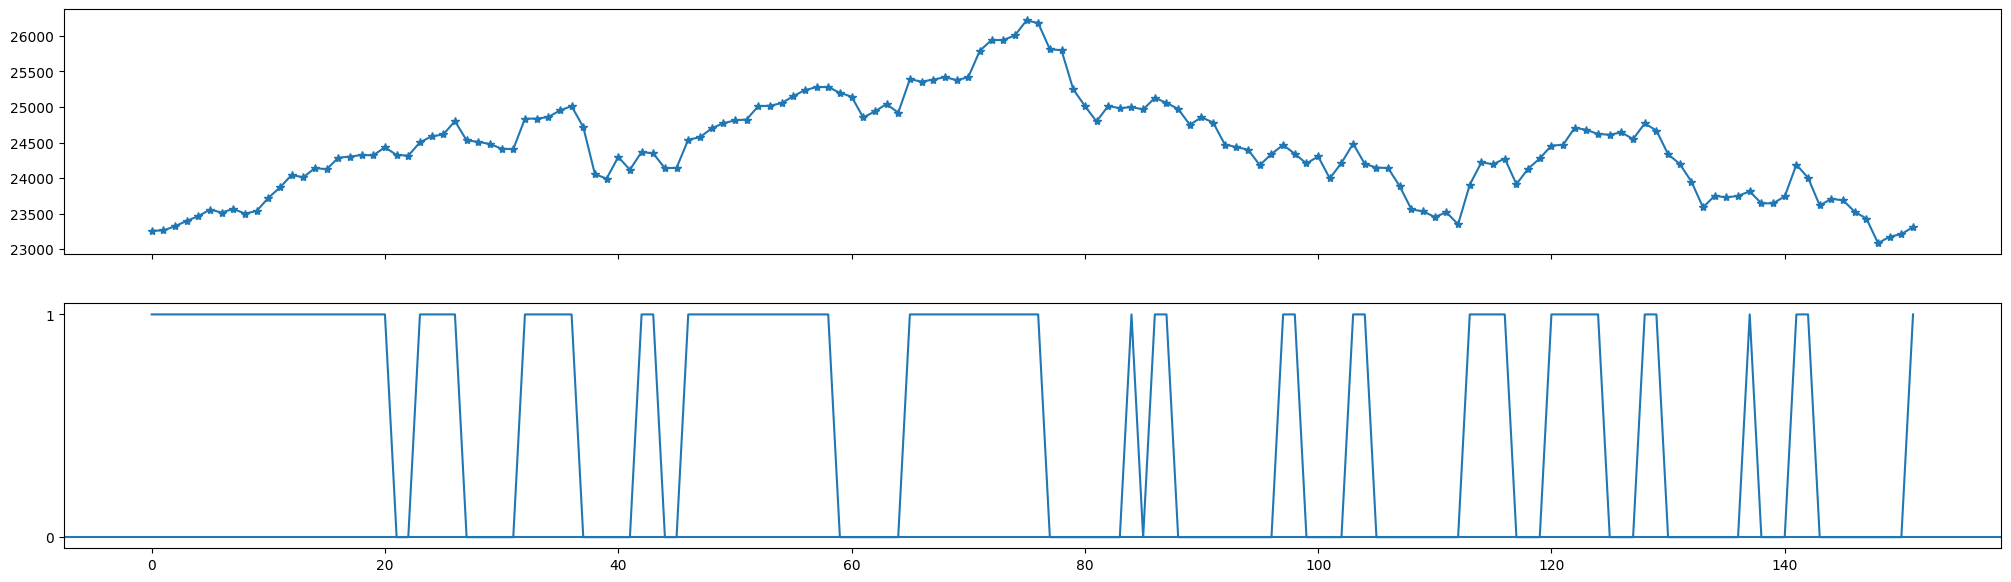

In [52]:
fig, ax = plt.subplots(2,1, figsize=(25,7),sharex=True)
ax[0].plot(pd.Series(price_data_new['Close'].values,),'*-')
rng = np.arange(-9,8,1)
ax[1].set_yticks(rng)
ax[1].plot(pd.Series(np.where(S_test_new.sum(axis=1)>0,1,0)))
#ax[1].plot(pd.Series(S_test_new[:].sum(axis=1)).ewm(span=20).mean())
ax[1].axhline(y=0);

In [53]:
price_data_new['Position']=(np.where(S_test_new.sum(axis=1)>0,1,0))
# Calculate returns based on NEXT DAY's Open price
price_data_new['Returns'] = (price_data_new['Open'].shift(-2) / price_data_new['Close'].shift(-1) - 1) * price_data_new['Position']


In [54]:
price_data_new['Open'].shift(-1).tail(5)

,Open
Date,
2025-01-10,23195.400391
2025-01-13,23165.900391
2025-01-14,23250.449219
2025-01-15,23377.250000
2025-01-16,NaN


In [55]:
price_data_new['Open'].tail(5)

,Open
Date,
2025-01-10,23551.900391
2025-01-13,23195.400391
2025-01-14,23165.900391
2025-01-15,23250.449219
2025-01-16,23377.250000


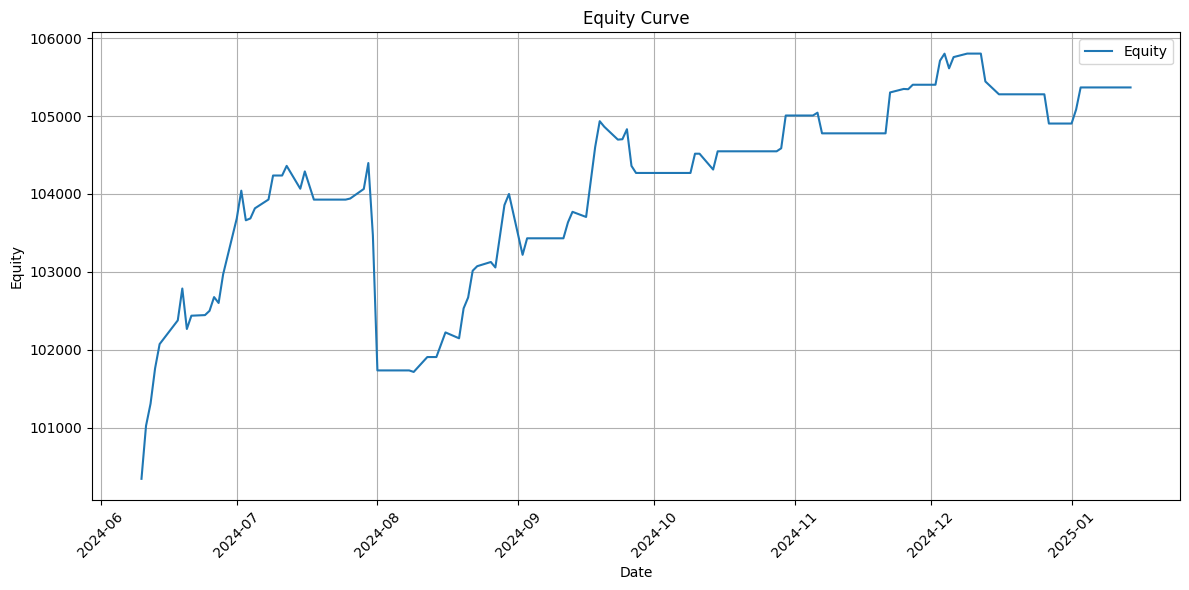

In [56]:
initial_capital = 100000
price_data_new['Equity'] = initial_capital * (1 + price_data_new['Returns']).cumprod()
# Plot the Equity Curve
plt.figure(figsize=(12, 6))  # Adjust figure size as desired
plt.plot(price_data_new.index, price_data_new['Equity'], label='Equity')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.title('Equity Curve')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

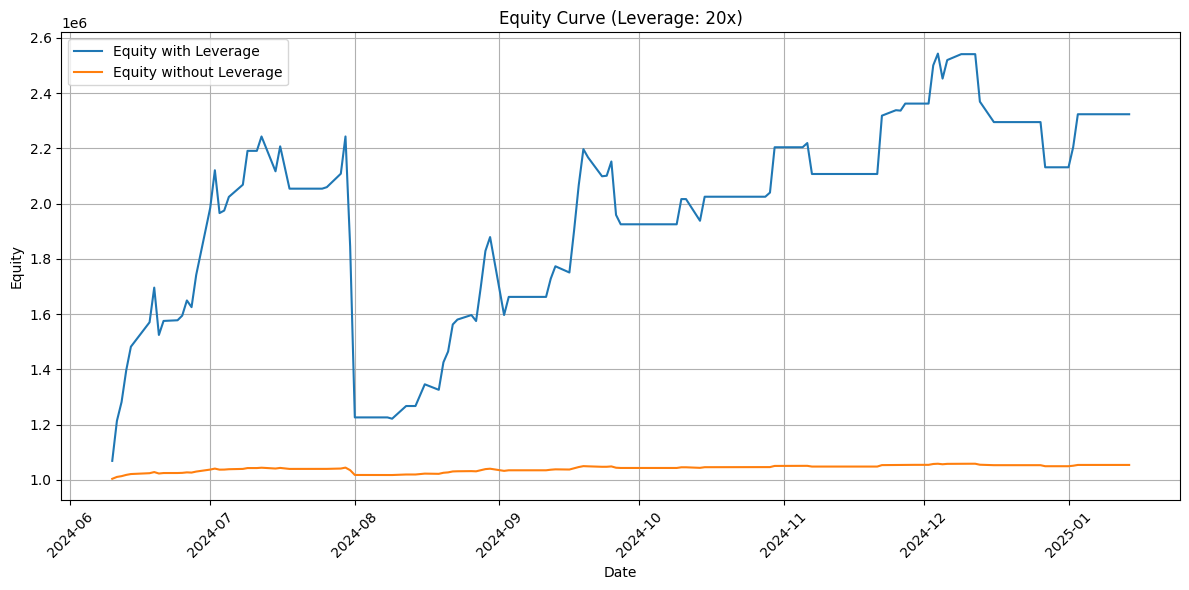

In [57]:

# Assuming price_data_new is already defined
initial_capital = 1000000
leverage = 20 # Set your desired leverage here

# Calculate leveraged returns
price_data_new['Leveraged_Returns'] = price_data_new['Returns'] * leverage

# Calculate equity with leverage
price_data_new['Equity'] = initial_capital * (1 + price_data_new['Leveraged_Returns']).cumprod()

# Calculate equity without leverage for comparison
price_data_new['Equity_No_Leverage'] = initial_capital * (1 + price_data_new['Returns']).cumprod()

# Plot the Equity Curves
plt.figure(figsize=(12, 6))
plt.plot(price_data_new.index, price_data_new['Equity'], label='Equity with Leverage')
plt.plot(price_data_new.index, price_data_new['Equity_No_Leverage'], label='Equity without Leverage')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.title(f'Equity Curve (Leverage: {leverage}x)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [58]:
def calculate_metrics(returns_series):
    """Calculates various trade metrics.

    Args:
        returns_series (pandas.Series): A Series of daily returns.

    Returns:
        dict: A dictionary containing the calculated metrics.
    """

    annualized_return = (1 + returns_series).prod() ** (252 / len(returns_series)) - 1
    annualized_std = returns_series.std() * np.sqrt(252)

    sharpe_ratio = annualized_return / annualized_std

    cumulative_returns = (1 + returns_series).cumprod()
    cumulative_max = cumulative_returns.cummax()
    drawdowns = cumulative_returns / cumulative_max - 1
    max_drawdown = drawdowns.min()
    calmar_ratio = annualized_return / abs(max_drawdown)

    # Calculate CAGR
    start_value = 1  # Initial investment
    end_value = (1 + returns_series).cumprod().iloc[-1]
    num_years = len(returns_series) / 252  # Assuming 252 trading days
    cagr = (end_value / start_value) ** (1 / num_years) - 1

    metrics = {
        'CAGR': cagr,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_std,
        'Sharpe Ratio': sharpe_ratio,
        'Calmar Ratio': calmar_ratio,
        'Max Drawdown': max_drawdown
    }

    return metrics

metrics = calculate_metrics(price_data_new['Returns'])

In [59]:
def calculate_metrics(returns_series, leverage=1, risk_free_rate=7.5):
    """Calculates various trade metrics with leverage.

    Args:
        returns_series (pandas.Series): A Series of daily returns.
        leverage (float): The leverage factor. Default is 1 (no leverage).
        risk_free_rate (float): The risk-free rate. Default is 0.

    Returns:
        dict: A dictionary containing the calculated metrics.
    """

    # Apply leverage to returns
    leveraged_returns = returns_series * leverage

    # Adjust for borrowing cost (simplified)
    borrowing_cost = (leverage - 1) * risk_free_rate / 252  # Daily borrowing cost
    net_leveraged_returns = leveraged_returns - borrowing_cost

    annualized_return = (1 + net_leveraged_returns).prod() ** (252 / len(net_leveraged_returns)) - 1
    annualized_std = net_leveraged_returns.std() * np.sqrt(252)

    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_std

    cumulative_returns = (1 + net_leveraged_returns).cumprod()
    cumulative_max = cumulative_returns.cummax()
    drawdowns = cumulative_returns / cumulative_max - 1
    max_drawdown = drawdowns.min()
    calmar_ratio = annualized_return / abs(max_drawdown)

    # Calculate CAGR
    start_value = 1  # Initial investment
    end_value = cumulative_returns.iloc[-1]
    num_years = len(net_leveraged_returns) / 252  # Assuming 252 trading days
    cagr = (end_value / start_value) ** (1 / num_years) - 1

    metrics = {
        'CAGR': cagr,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_std,
        'Sharpe Ratio': sharpe_ratio,
        'Calmar Ratio': calmar_ratio,
        'Max Drawdown': max_drawdown,
        'Leverage': leverage
    }

    return metrics

# Example usage:


In [60]:
metrics = calculate_metrics(price_data_new['Returns'], leverage=20, risk_free_rate=0.06)

In [61]:
for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

CAGR: nan
Annualized Return: 0.3163
Annualized Volatility: 0.8047
Sharpe Ratio: 0.3185
Calmar Ratio: 0.6299
Max Drawdown: -0.5022
Leverage: 20.0000


In [62]:
from sklearn.metrics import classification_report
y_pred=np.sign(np.where(S_test_new.sum(axis=1)==0,1,S_test_new.sum(axis=1)))
y_true=price_data_new['Close'].transform(lambda x : np.sign(x.diff(days_out)))
y_true=y_true.dropna()
y_pred=y_pred[-len(y_true):]
print("Classification Report Averaging")
print(classification_report(y_true, y_pred))

Classification Report Averaging
              precision    recall  f1-score   support

        -1.0       0.89      0.98      0.94        66
         1.0       0.99      0.90      0.94        83

    accuracy                           0.94       149
   macro avg       0.94      0.94      0.94       149
weighted avg       0.94      0.94      0.94       149



Precision

Downday (-1.0): Your model is correct about 62% of the time when predicting a downday.
Upday (1.0): Your model is very reliable, showing 92% precision in predicting updays.


Recall

Downday (-1.0): Your model identifies 83% of the actual downdays correctly.
Upday (1.0): Your model identifies 80% of the actual updays correctly.


F1-Score

Downday (-1.0): An F1-score of 0.71 indicates a decent balance between precision and recall for downdays.
Upday (1.0): A strong F1-score of 0.86 shows a good balance between precision and recall for updays.


Support: There are 12 downdays and 30 updays in the dataset.

Overall Assessment

Accuracy (0.81): The averaged model demonstrates a good overall accuracy of 81%.
Macro Average & Weighted Average: These provide a summary of the model's performance across both classes, considering the class imbalance in your dataset.

In [63]:
nifty50_url = "https://raw.githubusercontent.com/anirbanghoshsbi/data/main/ind_nifty50list.csv"
nifty50 = pd.read_csv(nifty50_url)
tickers = nifty50['Symbol'].apply(lambda x: x + ".NS").tolist()
# Bank Nifty Stocks
nifty_stocks = tickers

def calculate_percentage_above_moving_average(stock_list,periods,start_date):
    data = yf.download(stock_list, start=start_date)
    data = data['Adj Close']

    # Calculate the moving average using ewm with min_periods set to 50
    ma = data.ewm(span=periods, min_periods=periods).mean()

    above_ma = data > ma
    percentage = (above_ma.sum(axis=1) / len(stock_list)) * 100

    return percentage

# Calculate the percentage of stocks above their 200 DMA for each day
#percentage_above_dma = calculate_percentage_above_moving_average(nifty_stocks,200,'2020-05-01')
percentage_50_dma=calculate_percentage_above_moving_average(nifty_stocks,20,'2022-12-27')
# Download the Bank Nifty index data

[*********************100%***********************]  50 of 50 completed


In [64]:
percentage_above_dma_30_ema=percentage_50_dma.rolling(window=30).mean()
percentage_above_dma_10_ema=percentage_50_dma.rolling(window=10).mean()

In [65]:
result=percentage_above_dma_10_ema-percentage_above_dma_30_ema

In [66]:
import matplotlib.pyplot as plt

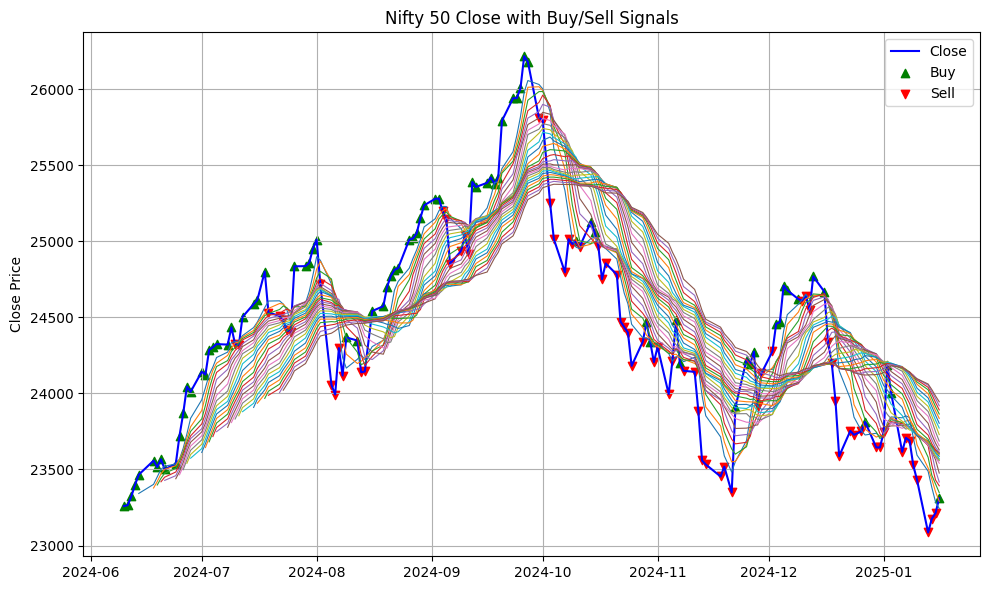

In [67]:
# First plot: Nifty 50 Close with Buy/Sell signals
fig, ax = plt.subplots(1, 1, figsize=(10, 6), sharex=True)

# Plot the close prices
ax.plot(price_data_new.index, price_data_new['Close'], label='Close', color='blue')

# Add Buy signals
ax.scatter(
    price_data_new.iloc[buy].index,
    price_data_new.iloc[buy]['Close'],
    marker='^',
    label='Buy',
    color='green'
)

# Add Sell signals
ax.scatter(
    price_data_new.iloc[sell].index,
    price_data_new.iloc[sell]['Close'],
    marker='v',
    label='Sell',
    color='red'
)

# Add legend and labels
ax.legend()
ax.set_title('Nifty 50 Close with Buy/Sell Signals')
ax.set_ylabel('Close Price')
ax.grid()

# Plot the moving averages on the first subplot
for window in range(5, 31):
    ax.plot(
        price_data_new.index,
        price_data_new['Close'].rolling(window=window).mean(),
        label=f'MA {window}',
        linewidth=0.8
    )




# Adjust layout and show the second plot
fig.tight_layout()
plt.show()


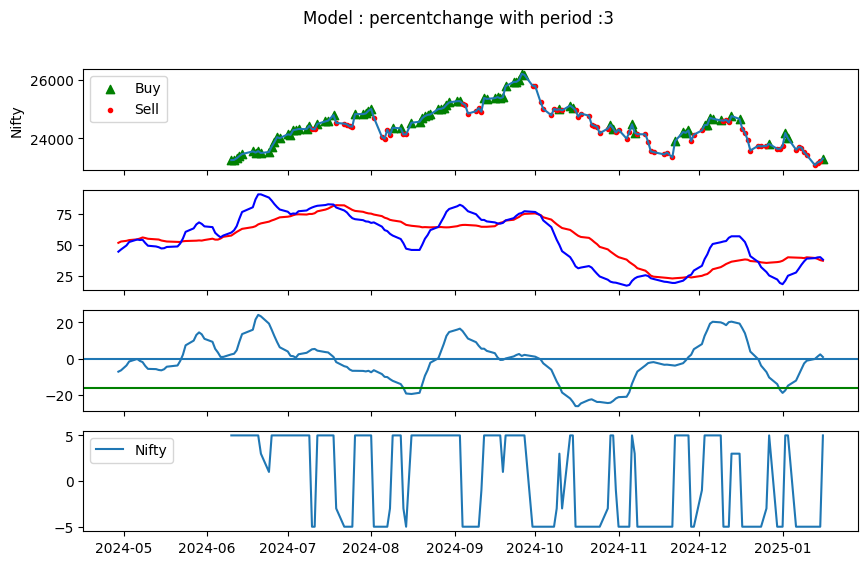

In [68]:
fig, ax = plt.subplots(4,1, figsize=(10,6),sharex=True)
ax[0].plot(price_data_new.loc[:, :].index, price_data_new.loc[:, 'Close'])
ax[3].plot(price_data_new.loc[:, :].index, y_pred_new_p, label='Nifty')
ax[0].scatter(price_data_new.iloc[buy].index,price_data_new.iloc[buy].Close,marker='^',label='Buy',color='g')
ax[0].scatter(price_data_new.iloc[sell].index,price_data_new.iloc[sell].Close,marker='.',label='Sell',color='r')
ax[1].plot(percentage_above_dma_30_ema[-180:],color='r')
ax[1].plot(percentage_above_dma_10_ema[-180:],color='b')
ax[2].plot(result[-180:] , label='up')
ax[0].legend(loc='upper left')
ax[2].axhline(y=0)
ax[2].axhline(y=-16,color='g')
ax[0].set_ylabel('Nifty')
ax[3].legend('ML Signal')
ax[3].legend(loc='best')
fig.suptitle('Model : '+ trend_decider +' with period :' + str(period))
plt.savefig('ml.png')
plt.show()


[*********************100%***********************]  51 of 51 completed
ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['SHRIRAMFIN.NS']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2016-01-01 -> 2025-01-16)')
ERROR:yfinance:['DUMMYITC.NS']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


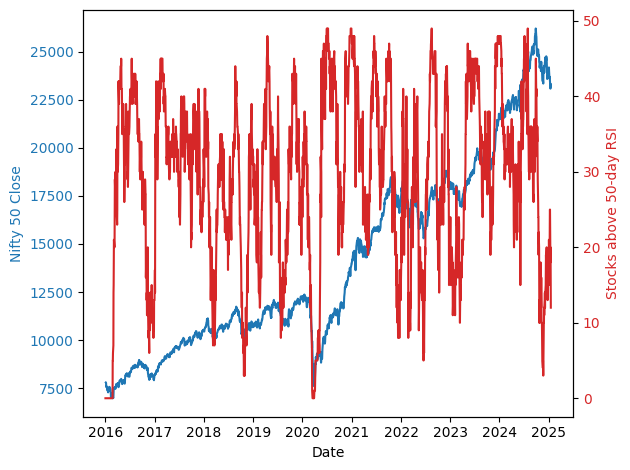

In [69]:
# Define the function to calculate RSI
def calculate_rsi(data):
    price_diff = data.diff()
    gains = price_diff.mask(price_diff < 0, 0)
    losses = -price_diff.mask(price_diff > 0, 0)
    avg_gain = gains.rolling(window=37).mean()
    avg_loss = losses.rolling(window=37).mean()
    relative_strength = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + relative_strength))
    return rsi
#ind_niftynext50list # ind_niftybanklist  #ind_nifty50list
# Fetch Nifty 50 constituents
nifty50_url = "https://archives.nseindia.com/content/indices/ind_nifty50list.csv"
nifty50 = pd.read_csv(nifty50_url)
tickers = nifty50['Symbol'].apply(lambda x: x + ".NS").tolist()

# Fetch historical data
start_date = "2016-01-01"
data = yf.download(tickers, start=start_date)['Adj Close']

# Calculate the RSI for each stock
rsi_data = data.apply(calculate_rsi)

# Check if RSI > 50
rsi_above_50 = rsi_data > 50

# Count the number of stocks having RSI > 50
num_stocks_above_50 = rsi_above_50.sum(axis=1)

# Fetch Nifty 50 index data
nifty50_data = yf.download("^NSEI", start=start_date)['Adj Close']

# Plot Nifty 50 close and cumulative count of stocks above 50-day moving average
fig, ax1 = plt.subplots()

ax1.set_xlabel('Date')
ax1.set_ylabel('Nifty 50 Close', color='tab:blue')
ax1.plot(nifty50_data.index, nifty50_data, color='tab:blue', label='Nifty 50 Close')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Stocks above 50-day RSI', color='tab:red')
ax2.plot(num_stocks_above_50.index, num_stocks_above_50, color='tab:red', label='Stocks above 50-day RSI')
ax2.tick_params(axis='y', labelcolor='tab:red')
#ax2.axhline(y=18)
fig.tight_layout()
plt.show()

In [70]:
num_stocks_above_50=num_stocks_above_50.tail(200)
nifty50_data=nifty50_data.tail(200)

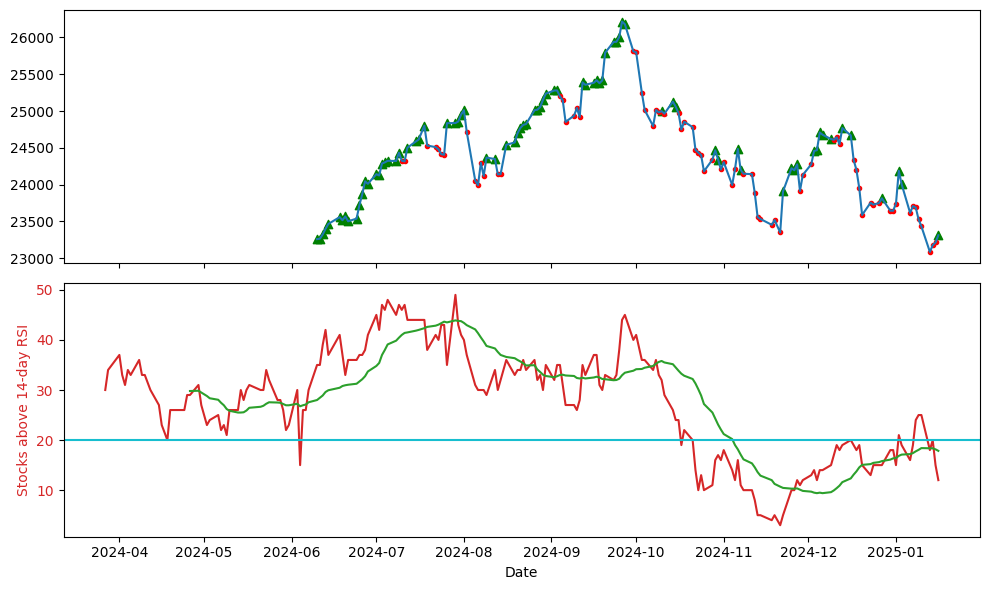

In [71]:
# Plot Nifty 50 close and cumulative count of stocks above 50-day moving average in separate subplots
fig, ax = plt.subplots(2,1, figsize=(10,6),sharex=True)

ax[0].plot(price_data_new.loc[:, :].index, price_data_new.loc[:, 'Close'])
ax[0].scatter(price_data_new.iloc[buy].index,price_data_new.iloc[buy].Close,marker='^',label='Buy',color='g')
ax[0].scatter(price_data_new.iloc[sell].index,price_data_new.iloc[sell].Close,marker='.',label='Sell',color='r')

ax[1].set_xlabel('Date')
ax[1].set_ylabel('Stocks above 14-day RSI', color='tab:red')
ax[1].plot(num_stocks_above_50.index, num_stocks_above_50, color='tab:red', label='Stocks above 14-day RSI')
ax[1].plot(num_stocks_above_50.index, num_stocks_above_50.rolling(window=20).mean(), color='tab:green', label='Mavg 20')
ax[1].axhline(y=20,color='tab:cyan')
ax[1].tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()

# Show the plot
plt.show()